In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/Users/dashivam06/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Read the CSV file containing Kathmandu air quality measurements into a DataFrame
df = pd.read_csv("kathmandu_pm25_dataset.csv")

print("Length of the dataset: ", len(df), "\n\n")
df.head()

Length of the dataset:  61976 




,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,o3,0.051,ppm,27.712463,85.315704
1,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,pm25,69.000,µg/m³,27.712463,85.315704
2,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,pm25,69.000,µg/m³,27.712463,85.315704
3,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,o3,0.030,ppm,27.712463,85.315704
4,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T16:15:00+00:00,2021-03-12T22:00:00+05:45,o3,0.030,ppm,27.712463,85.315704


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61976 entries, 0 to 61975
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   locationId  61976 non-null  int64  
 1   location    61976 non-null  object 
 2   city        61976 non-null  object 
 3   country     61976 non-null  object 
 4   utc         61976 non-null  object 
 5   local       61976 non-null  object 
 6   parameter   61976 non-null  object 
 7   value       61976 non-null  float64
 8   unit        61976 non-null  object 
 9   latitude    61976 non-null  float64
 10  longitude   61976 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 5.2+ MB


In [4]:
# Keep only the rows where the 'parameter' column is 'pm25'
# This removes other pollutants if they exist (e.g., o3, etc.)
pm25_df = df[df["parameter"] == "pm25"].copy()

print("Length of the dataset: ", len(pm25_df), "\n\n")
pm25_df.head()

Length of the dataset:  31832 




,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
1,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,pm25,69.0,µg/m³,27.712463,85.315704
2,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,pm25,69.0,µg/m³,27.712463,85.315704
5,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T16:15:00+00:00,2021-03-12T22:00:00+05:45,pm25,60.0,µg/m³,27.712463,85.315704
6,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T15:15:00+00:00,2021-03-12T21:00:00+05:45,pm25,58.0,µg/m³,27.712463,85.315704
9,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T14:15:00+00:00,2021-03-12T20:00:00+05:45,pm25,58.0,µg/m³,27.712463,85.315704


In [5]:
# Convert 'local' and 'utc' columns from string to datetime objects
# This allows proper time-based operations (resampling, filtering, etc.)
pm25_df["local"] = pd.to_datetime(pm25_df["local"])
pm25_df["utc"] = pd.to_datetime(pm25_df["utc"])
pm25_df.head()

,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
1,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12 18:15:00+00:00,2021-03-13 00:00:00+05:45,pm25,69.0,µg/m³,27.712463,85.315704
2,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12 17:15:00+00:00,2021-03-12 23:00:00+05:45,pm25,69.0,µg/m³,27.712463,85.315704
5,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12 16:15:00+00:00,2021-03-12 22:00:00+05:45,pm25,60.0,µg/m³,27.712463,85.315704
6,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12 15:15:00+00:00,2021-03-12 21:00:00+05:45,pm25,58.0,µg/m³,27.712463,85.315704
9,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12 14:15:00+00:00,2021-03-12 20:00:00+05:45,pm25,58.0,µg/m³,27.712463,85.315704


In [6]:
# Remove columns that are not needed for this analysis to simplify the dataset
pm25_df = pm25_df.drop(columns = ["location","city","latitude","longitude","country"])
pm25_df.head()

,locationId,utc,local,parameter,value,unit
1,3460,2021-03-12 18:15:00+00:00,2021-03-13 00:00:00+05:45,pm25,69.0,µg/m³
2,3460,2021-03-12 17:15:00+00:00,2021-03-12 23:00:00+05:45,pm25,69.0,µg/m³
5,3460,2021-03-12 16:15:00+00:00,2021-03-12 22:00:00+05:45,pm25,60.0,µg/m³
6,3460,2021-03-12 15:15:00+00:00,2021-03-12 21:00:00+05:45,pm25,58.0,µg/m³
9,3460,2021-03-12 14:15:00+00:00,2021-03-12 20:00:00+05:45,pm25,58.0,µg/m³


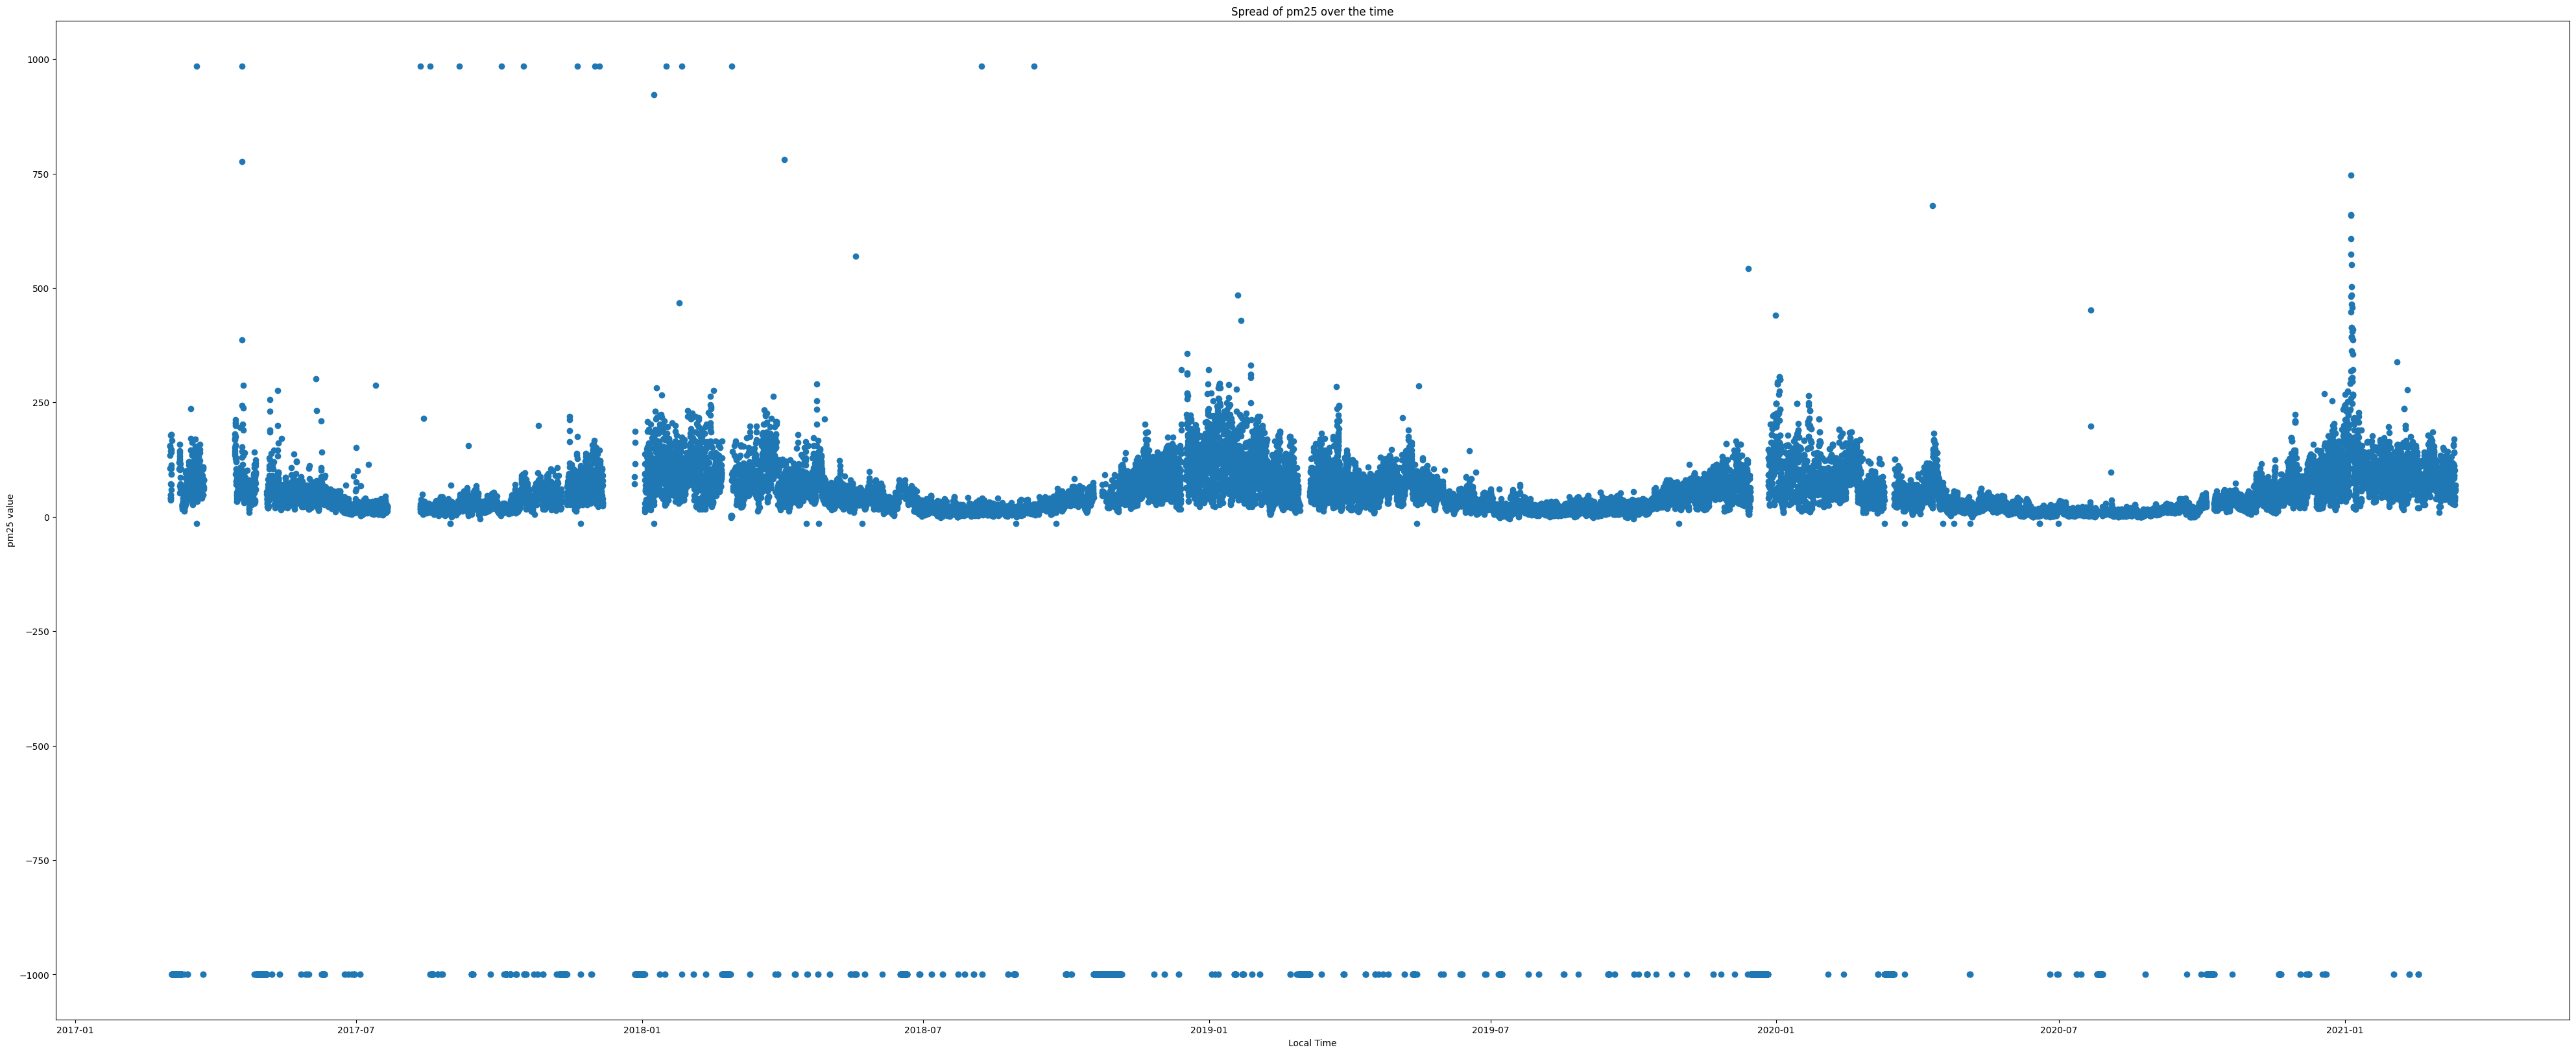

In [7]:
# Create a large scatter plot of PM2.5 values over local time for the full time series
plt.figure(figsize=(50, 20))
plt.scatter(pm25_df["local"],pm25_df["value"])
plt.title("Spread of pm25 over the time")
plt.xlabel("Local Time")
plt.ylabel("pm25 value")
plt.show()


In [8]:
# In reality, PM2.5 levels never drop to zero. 
# Furthermore, there is no historical record of concentrations exceeding $370 µg/m³$ in Kathmandu. 
# Values outside this range are likely sensor errors; therefore, we will treat them as outliers 
# and use backfill (bfill) followed by forward fill (ffill) to impute the missing data.

# Count's how many values are abnormally high (>= 102)
count = (pm25_df["value"] >=102).sum()

# Why 102 and why not 100 ?
# Selected 102 as the upper threshold based on model tuning. While 100 is standard, 
# 102 optimized the r^2 score, preserving valid high-pollution peaks while removing true sensor noise.

print("No of outliers/invalid data in pm25:" ,count)

# Count's how many values are zero or negative (physically impossible for concentration)
negative_pm25_values = (pm25_df["value"] <= 0).sum()
print("No of negative/invalid data in pm25:" ,negative_pm25_values)


No of outliers/invalid data in pm25: 3910
No of negative/invalid data in pm25: 2477


In [9]:
# Total invalid values before replacing them with NaN
print("Total Invalid value count before replacing:  " + str((negative_pm25_values + count)))

# Create a new column that will store cleaned PM2.5 values
pm25_df["clean_value"] = pm25_df["value"].copy()

# Replace clearly invalid values (<= 3 or >= 102) with NaN in 'clean_value'
# These NaNs will later be filled using forward/backward fill
pm25_df.loc[(pm25_df["value"] <= 3) | (pm25_df["value"] >= 102),"clean_value"] = pd.NA

# Count how many NaNs are in the cleaned column
invalid_count = pm25_df["clean_value"].isna().sum()

print("Total count of Nan value in dataframe before removing the nan:" , invalid_count)

print(pm25_df[["local","clean_value","value","parameter"]].head())

Total Invalid value count before replacing:  6387
Total count of Nan value in dataframe before removing the nan: 6692
                      local  clean_value  value parameter
1 2021-03-13 00:00:00+05:45         69.0   69.0      pm25
2 2021-03-12 23:00:00+05:45         69.0   69.0      pm25
5 2021-03-12 22:00:00+05:45         60.0   60.0      pm25
6 2021-03-12 21:00:00+05:45         58.0   58.0      pm25
9 2021-03-12 20:00:00+05:45         58.0   58.0      pm25


In [10]:
# Create a binary flag column where 1 means the sensor is "down" (invalid/NaN clean_value) and 0 means the sensor is working normally
pm25_df["sensor_down"] = pm25_df["clean_value"].isna().astype(int)

print(pm25_df[["local","clean_value","value","parameter","sensor_down"]].sort_values(by="value", ascending=False).head())


                          local  clean_value  value parameter  sensor_down
55115 2017-09-05 11:00:00+05:45          NaN  985.0      pm25            1
49978 2018-01-26 12:00:00+05:45          NaN  985.0      pm25            1
48840 2018-02-27 15:00:00+05:45          NaN  985.0      pm25            1
51369 2017-12-04 10:00:00+05:45          NaN  985.0      pm25            1
51482 2017-12-01 12:00:00+05:45          NaN  985.0      pm25            1


/var/folders/5h/wdf3vc9s0cb3k4pj_zh03f300000gn/T/ipykernel_68011/1190690071.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_downtime = pm25_df.groupby(pm25_df["local"].dt.to_period("M"))["sensor_down"].sum()


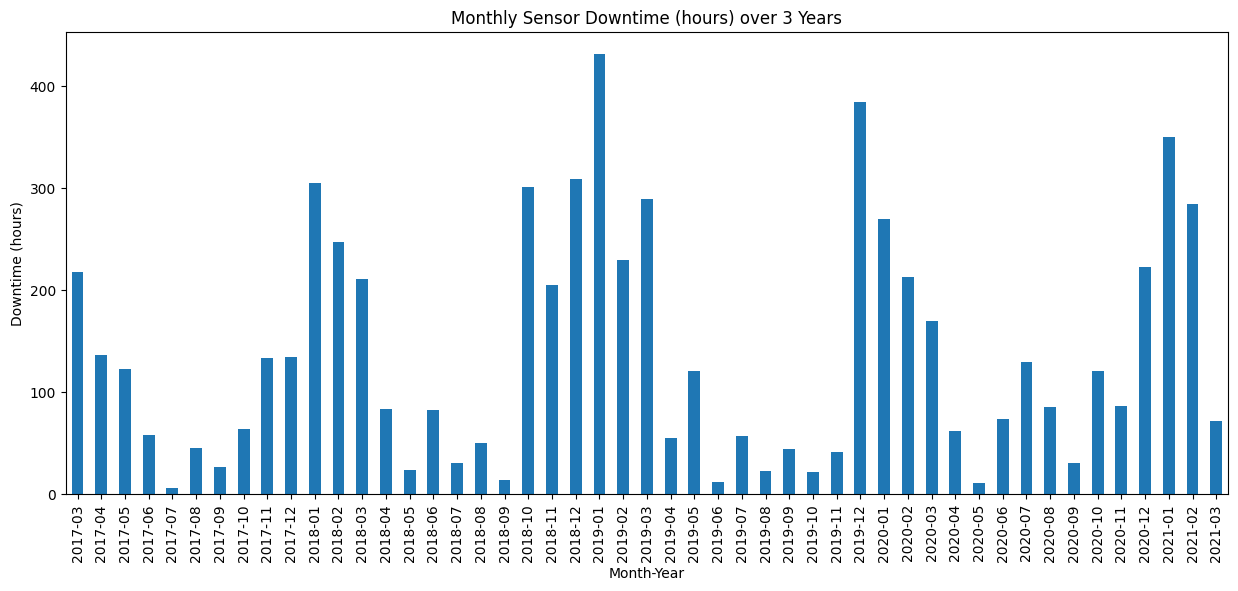

In [11]:
# Group by month (using the 'local' datetime) and sum the sensor_down flags
# Each row represents one hour, so the sum is the total hours of downtime per month
monthly_downtime = pm25_df.groupby(pm25_df["local"].dt.to_period("M"))["sensor_down"].sum()

monthly_downtime.head()

# Plot monthly downtime as a bar chart
plt.figure(figsize=(15,6))
monthly_downtime.plot(kind="bar")
plt.title("Monthly Sensor Downtime (hours) over 3 Years")
plt.xlabel("Month-Year")
plt.ylabel("Downtime (hours)")
plt.show()


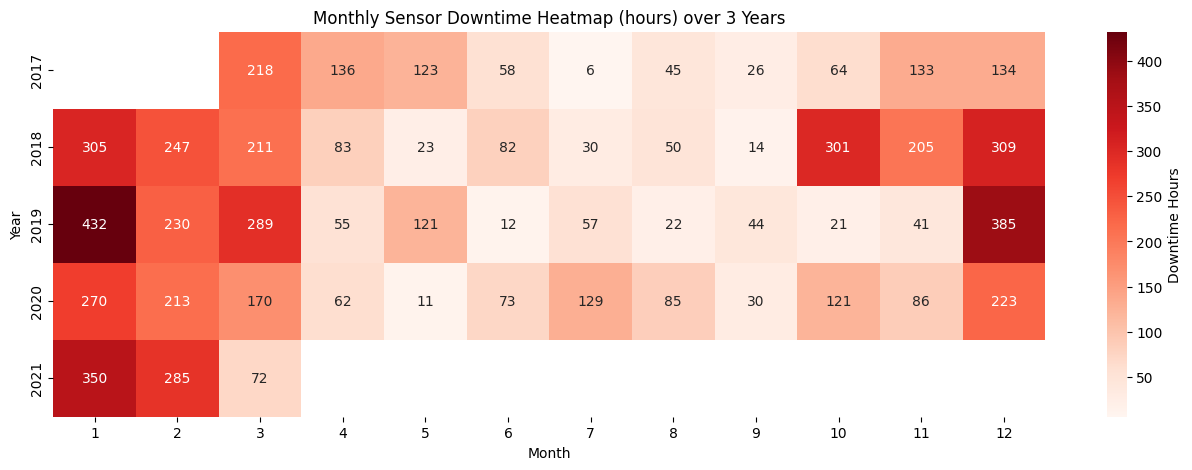

In [12]:
# Convert PeriodIndex back to a normal column for further processing
monthly_downtime = monthly_downtime.reset_index()
monthly_downtime["Year"] = monthly_downtime["local"].dt.year
monthly_downtime["Month"] = monthly_downtime["local"].dt.month

# Create a pivot table: rows = Year, columns = Month, values = downtime hours
heatmap_data = monthly_downtime.pivot(index="Year", columns="Month", values="sensor_down")


# Plot a heatmap to visualize downtime intensity by year and month
plt.figure(figsize=(16,5))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': 'Downtime Hours'})
plt.title("Monthly Sensor Downtime Heatmap (hours) over 3 Years")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


In [13]:
# Fill NaNs in clean_value using backward fill (bfill) up to 3 hours, then forward fill (ffill) up to 3 hours.
pm25_df["value_filled"] = pm25_df["clean_value"].bfill(limit=3).ffill(limit=3)

# Count remaining NaNs after filling
invalid_count = pm25_df["value_filled"].isna().sum()

print("Total count of Nan value in dataframe after filling:" , invalid_count)

print(pm25_df[["local","clean_value","value","parameter","value_filled"]].head())


Total count of Nan value in dataframe after filling: 2614
                      local  clean_value  value parameter  value_filled
1 2021-03-13 00:00:00+05:45         69.0   69.0      pm25          69.0
2 2021-03-12 23:00:00+05:45         69.0   69.0      pm25          69.0
5 2021-03-12 22:00:00+05:45         60.0   60.0      pm25          60.0
6 2021-03-12 21:00:00+05:45         58.0   58.0      pm25          58.0
9 2021-03-12 20:00:00+05:45         58.0   58.0      pm25          58.0


In [14]:
# Check if all consecutive timestamps are exactly 1 hour apart (returns True/False)
(pm25_df['local'].diff().dropna().abs() == pd.Timedelta(hours=1)).all()

# Ensure the data is sorted by time
pm25_df = pm25_df.sort_values('local').reset_index(drop=True)

# Find rows where the time difference is NOT 1 hour (potential gaps or irregularities)
pm25_df.loc[
    pm25_df['local'].diff().abs() != pd.Timedelta(hours=1),
    ['local']
].head()

# pm25_df.loc[pm25_df['local'].diff() != pd.Timedelta(hours=1), ['local']]



,local
0,2017-03-03 05:00:00+05:45
138,2017-03-09 03:00:00+05:45
209,2017-03-12 03:00:00+05:45
516,2017-04-13 20:00:00+05:45
2822,2017-07-19 03:00:00+05:45


In [15]:
# Create lag features: PM2.5 from the previous 1, 2, 3, and (duplicated) 3 hours
# These will be used as inputs to prediction models
pm25_df['lag1'] = pm25_df['value_filled'].shift(1)
pm25_df['lag2'] = pm25_df['value_filled'].shift(2)
pm25_df['lag3'] = pm25_df['value_filled'].shift(3)
pm25_df['lag4'] = pm25_df['value_filled'].shift(3)


print("Before dropping the NaN from the lag features: \n")
print(pm25_df[["local","value_filled","lag1","lag2","lag3"]].head(10))


# Remove rows where lag features or target are NaN (these occur at the start of the series)
print("\n\nAfter dropping the NaN from the lag features: \n")
pm25_df = pm25_df.dropna(subset=["lag1","lag2","lag3","value_filled"])

# Keep only rows where the last 3 lags are truly 1, 2, and 3 hours apart
pm25_df = pm25_df[
    (pm25_df['local'] - pm25_df['local'].shift(1) == pd.Timedelta(hours=1)) &
    (pm25_df['local'] - pm25_df['local'].shift(2) == pd.Timedelta(hours=2)) &
    (pm25_df['local'] - pm25_df['local'].shift(3) == pd.Timedelta(hours=3))
]

print(pm25_df[["local","value_filled","lag1","lag2","lag3"]].head(10))


Before dropping the NaN from the lag features: 

                      local  value_filled  lag1  lag2  lag3
0 2017-03-03 05:00:00+05:45           NaN   NaN   NaN   NaN
1 2017-03-03 06:00:00+05:45           NaN   NaN   NaN   NaN
2 2017-03-03 07:00:00+05:45           NaN   NaN   NaN   NaN
3 2017-03-03 08:00:00+05:45           NaN   NaN   NaN   NaN
4 2017-03-03 09:00:00+05:45          72.1   NaN   NaN   NaN
5 2017-03-03 10:00:00+05:45          72.1  72.1   NaN   NaN
6 2017-03-03 11:00:00+05:45          72.1  72.1  72.1   NaN
7 2017-03-03 12:00:00+05:45          72.1  72.1  72.1  72.1
8 2017-03-03 13:00:00+05:45          48.0  72.1  72.1  72.1
9 2017-03-03 14:00:00+05:45          40.0  48.0  72.1  72.1


After dropping the NaN from the lag features: 

                       local  value_filled  lag1  lag2  lag3
10 2017-03-03 15:00:00+05:45          36.0  40.0  48.0  72.1
11 2017-03-03 16:00:00+05:45          48.5  36.0  40.0  48.0
12 2017-03-03 17:00:00+05:45          41.7  48.5  36.0  40

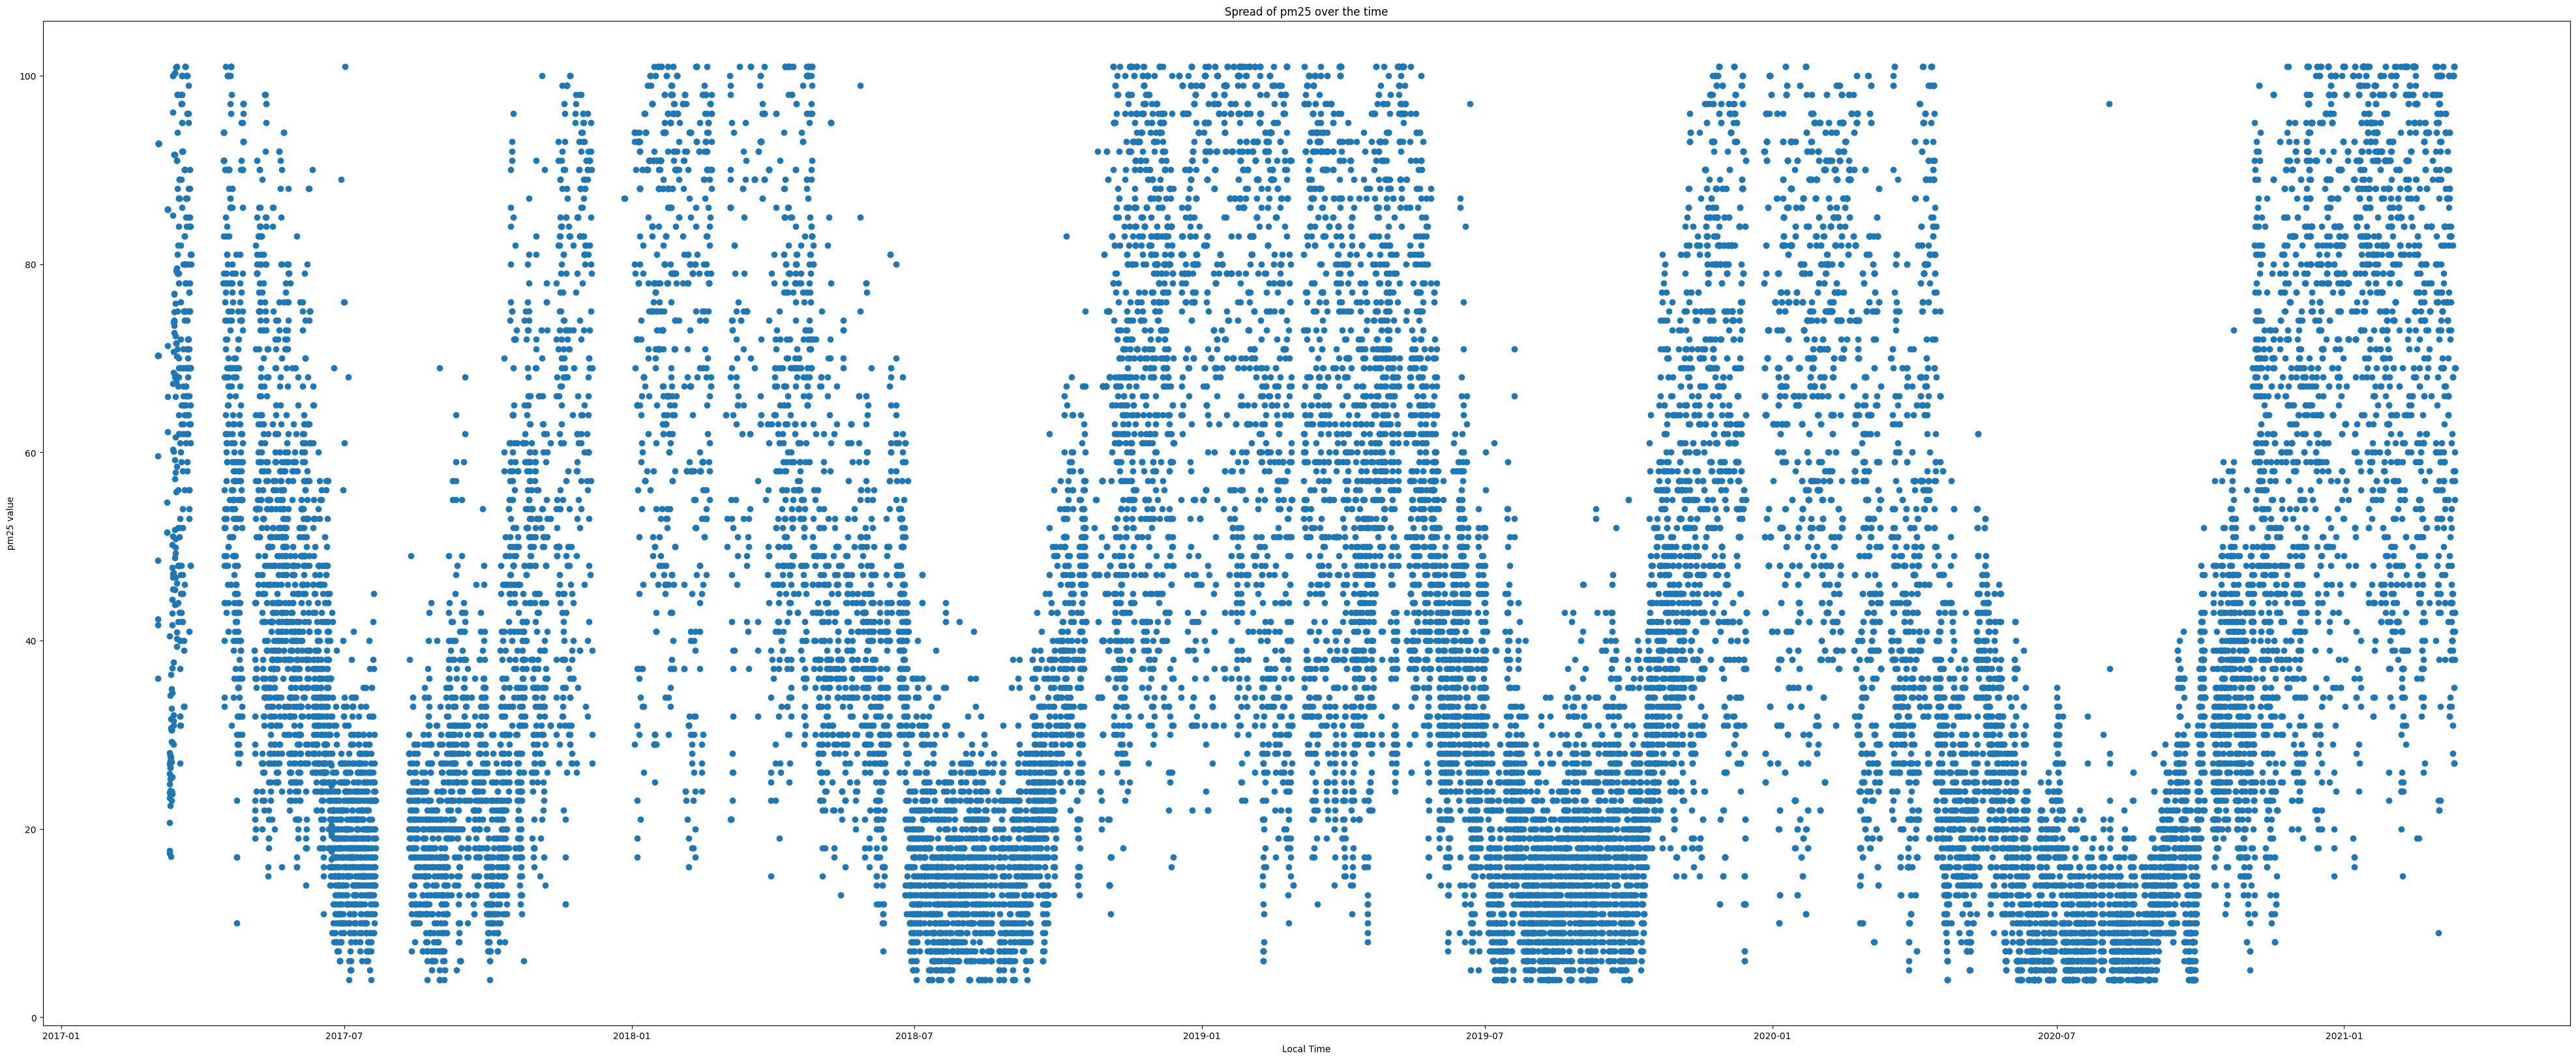

In [16]:
# Plot the time series using the filled values instead of raw values
plt.figure(figsize=(50,20))
plt.scatter(pm25_df["local"],pm25_df["value_filled"])
plt.title("Spread of pm25 over the time")
plt.xlabel("Local Time")
plt.ylabel("pm25 value")
plt.show()


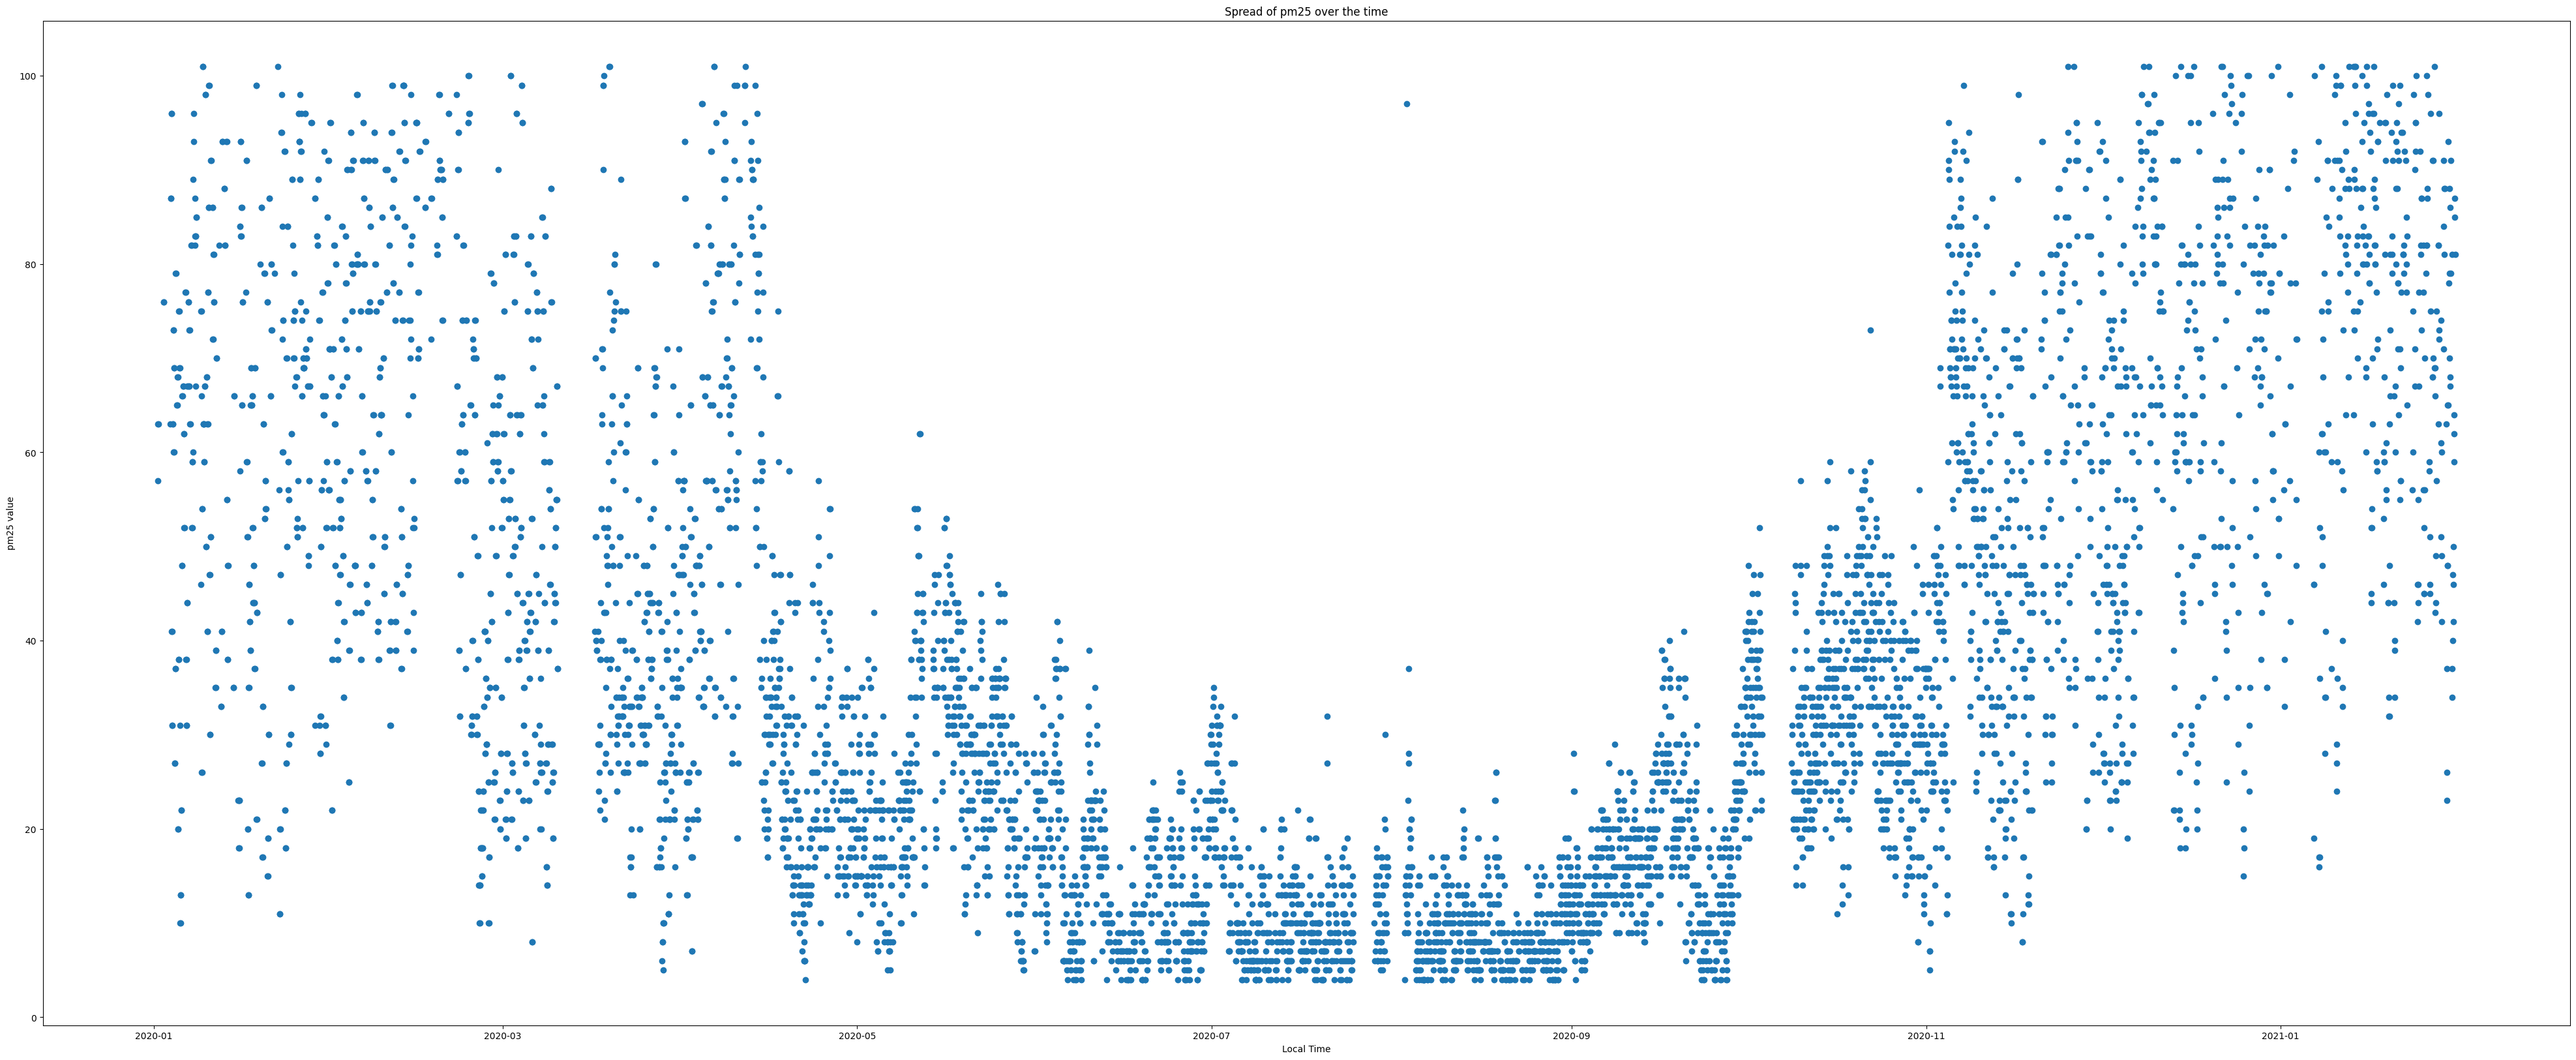

In [17]:
# Filter data for the COVID period: Jan 2020 to Jan 2021
covid_period = pm25_df[(pm25_df["local"] >= '2020-01-01') & (pm25_df["local"] <= '2021-01-31')]

# Visualize PM2.5 during the COVID period using cleaned values
plt.figure(figsize=(50,20))
plt.scatter(covid_period["local"], covid_period["clean_value"])
plt.title("Spread of pm25 over the time")
plt.xlabel("Local Time")
plt.ylabel("pm25 value")
plt.show()


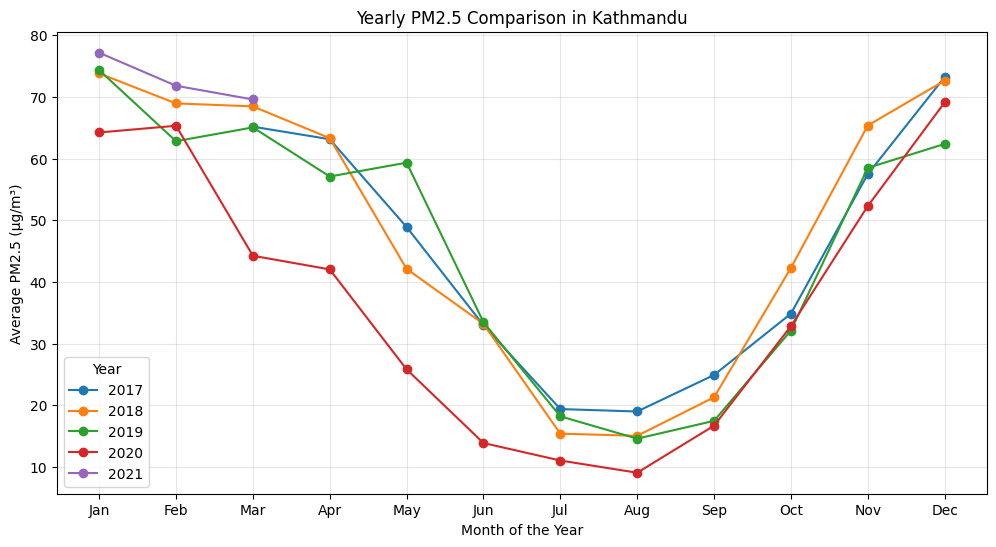

In [18]:

# Add year and month columns for longer-term trend analysis
pm25_df['year'] = pm25_df['local'].dt.year
pm25_df['month'] = pm25_df['local'].dt.month

# Compute monthly average PM2.5 for each year
yearly_trend = pm25_df.groupby(['year', 'month'])['value_filled'].mean().unstack(level=0)

# Plot yearly monthly curves to compare seasons across years
plt.figure(figsize=(12, 6))
yearly_trend.plot(ax=plt.gca(), marker='o')
plt.title("Yearly PM2.5 Comparison in Kathmandu")
plt.xlabel("Month of the Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.legend(title="Year")
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/5h/wdf3vc9s0cb3k4pj_zh03f300000gn/T/ipykernel_68011/3040548315.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trend = pm25_df.resample('M', on='local')['value_filled'].mean().reset_index()


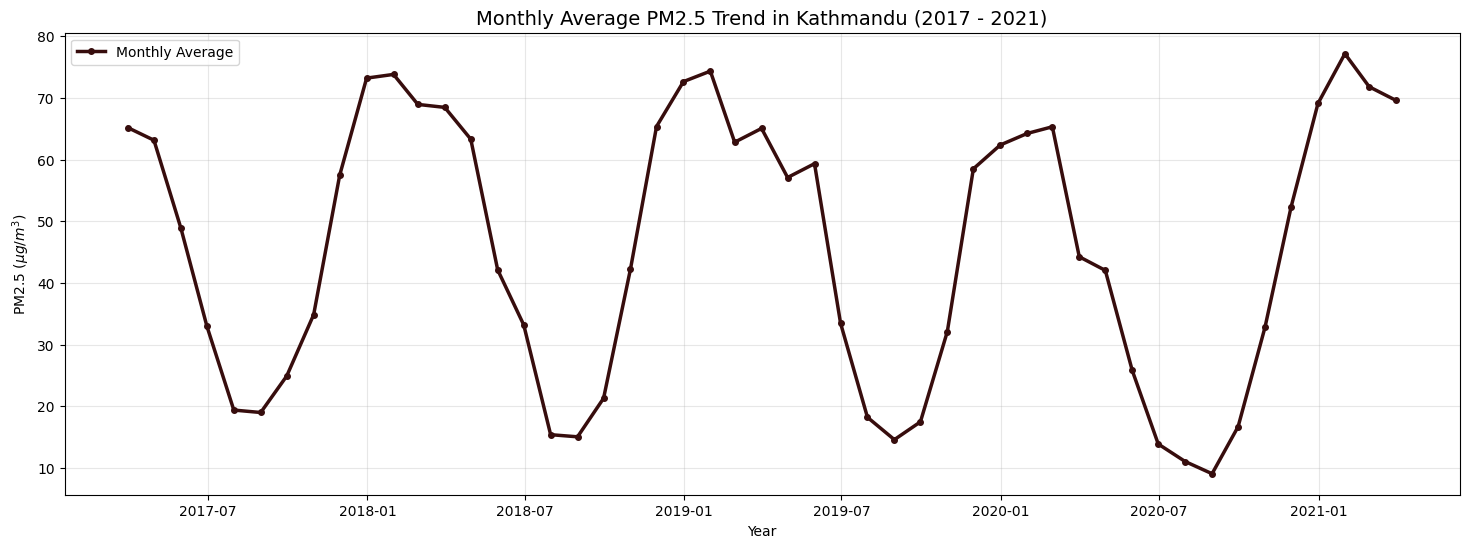

In [19]:
# Resample the full dataset to monthly frequency and take the mean PM2.5
monthly_trend = pm25_df.resample('M', on='local')['value_filled'].mean().reset_index()

# 2. Plot the smoothed line
plt.figure(figsize=(18, 6))

# Use a thicker line and markers to make the monthly points clear
plt.plot(monthly_trend['local'], monthly_trend['value_filled'], 
         color="#370d0d", linewidth=2.5, marker='o', markersize=4, label='Monthly Average')

plt.title("Monthly Average PM2.5 Trend in Kathmandu (2017 - 2021)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("PM2.5 ($µg/m^3$)")
plt.grid(True, alpha=0.3)

plt.legend()
plt.show()

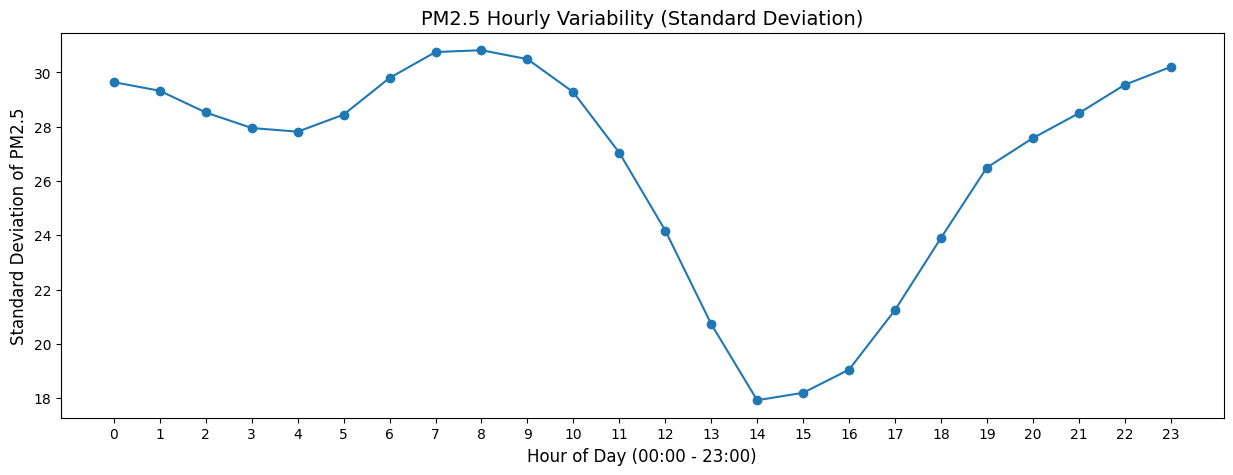

In [20]:
# Question : Which hours are most unpredictable?

pm25_df_hourly_var = pm25_df.groupby(pm25_df["local"].dt.hour)["value_filled"].std()
ax =  pm25_df_hourly_var.plot(kind='line', marker='o', figsize=(15, 5))
ax.set_title("PM2.5 Hourly Variability (Standard Deviation)", fontsize=14)
ax.set_xlabel("Hour of Day (00:00 - 23:00)", fontsize=12)
ax.set_ylabel("Standard Deviation of PM2.5", fontsize=12)
ax.set_xticks(range(0, 24))
plt.show()

--- Daily PM2.5 Means ---
day_type
weekday    44.910679
weekend    44.376522
Name: value_filled, dtype: float64
---------------------------



<Figure size 600x500 with 0 Axes>

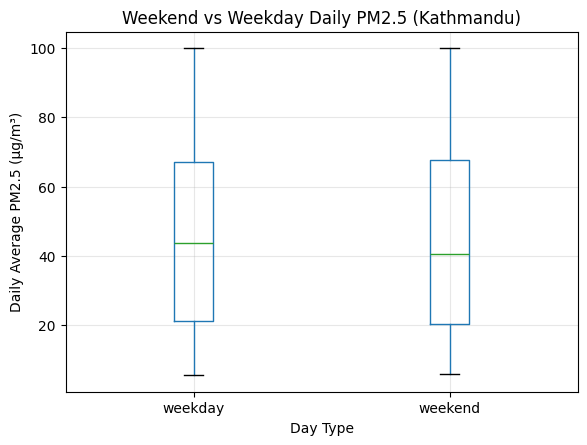

In [21]:
# Myth Buster : Is PM2.5 in Kathmandu significantly lower on weekends (Saturday) compared to weekdays?
pm25_df["day_type"] = pm25_df["local"].dt.dayofweek.apply(
    lambda x: "weekend" if x == 6 else "weekday"
)
daily_pm25 = (
    pm25_df
    .groupby([pm25_df["local"].dt.date, "day_type"])["value_filled"]
    .mean()
    .reset_index()
)

print("--- Daily PM2.5 Means ---")
print(daily_pm25.groupby("day_type")["value_filled"].mean())
print("---------------------------\n")


plt.figure(figsize=(6,5))
daily_pm25.boxplot(column="value_filled", by="day_type")

plt.title("Weekend vs Weekday Daily PM2.5 (Kathmandu)")
plt.suptitle("")
plt.xlabel("Day Type")
plt.ylabel("Daily Average PM2.5 (µg/m³)")
plt.grid(alpha=0.3)
plt.show()


In [22]:
# Split data into training (before 2020) and testing (after 2020-01-01)
train = pm25_df[pm25_df["local"] < "2020-01-01"]
test = pm25_df[pm25_df["local"] > "2020-01-01"]

# Features: lagged values; Target: current PM2.5
X_train = train[['lag1', 'lag2', 'lag3']]
y_train = train['value_filled']

X_test = test[['lag1', 'lag2', 'lag3']]
y_test = test['value_filled']

In [23]:
# from sklearn.model_selection import train_test_split

# # Define your features (X) and target (y) from the whole dataset
# X = pm25_df[['lag1', 'lag2', 'lag3']]
# y = pm25_df['value_filled']

# # Split randomly: 80% for training and 20% for testing
# # random_state ensures you get the same "random" split every time you run the code
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# Initialize a simple linear regression model
linear_model = LinearRegression()

# Fit the model using lag features as predictors
linear_model.fit(X_train,y_train)

# Predict PM2.5 values on the test set
lg__y_pred = linear_model.predict(X_test)

# Calculate evaluation metrics: MSE, MAE, R², and RMSE
lg_mse = mean_squared_error(y_test, lg__y_pred)
lg_mae = mean_absolute_error(y_test, lg__y_pred)
lg_r2 = r2_score(y_test, lg__y_pred)
lg_rmse = math.sqrt(lg_mse)

print("\n" + "╔══════════════════════════════════════════╗")
print( "║   LINEAR REGRESSION EVALUATION METRICS   ║")
print( "╠══════════════════════════════════════════╣")
print(f"║  RMSE: {lg_rmse:>30.6f}    ║")
print( "╠══════════════════════════════════════════╣")
print(f"║  MSE:  {lg_mse:>30.6f}    ║")
print( "╠══════════════════════════════════════════╣")
print(f"║  MAE:  {lg_mae:>30.6f}    ║")
print( "╠══════════════════════════════════════════╣")
print(f"║  R²:   {lg_r2:>30.6f}    ║")
print( "╚══════════════════════════════════════════╝")



╔══════════════════════════════════════════╗
║   LINEAR REGRESSION EVALUATION METRICS   ║
╠══════════════════════════════════════════╣
║  RMSE:                       9.666691    ║
╠══════════════════════════════════════════╣
║  MSE:                       93.444918    ║
╠══════════════════════════════════════════╣
║  MAE:                        5.954900    ║
╠══════════════════════════════════════════╣
║  R²:                         0.891906    ║
╚══════════════════════════════════════════╝


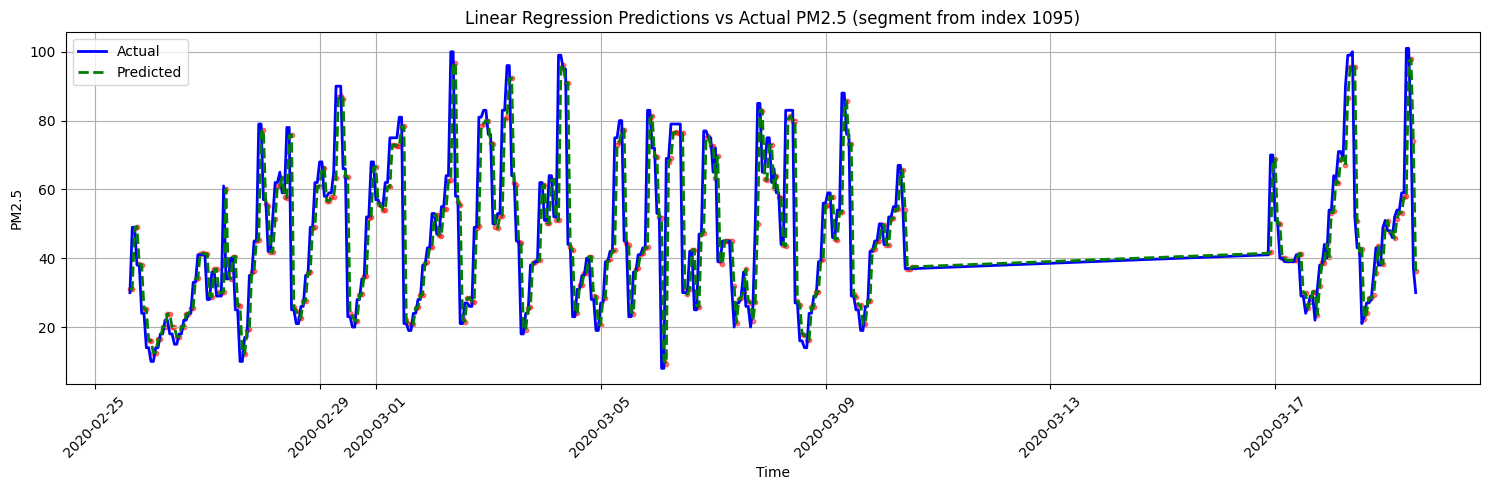

In [25]:
# Compare actual vs predicted PM2.5 over time for the test period

import matplotlib.pyplot as plt
import numpy as np

# Number of points to visualize
n_points = 400  # adjust as needed

# Random starting index
start_idx = np.random.randint(0, len(y_test) - n_points)

# Select segment
time_segment = test['local'].iloc[start_idx:start_idx + n_points]
y_true_segment = y_test[start_idx:start_idx + n_points]
lg_pred_segment = lg__y_pred[start_idx:start_idx + n_points]

plt.figure(figsize=(15,5))
plt.plot(time_segment, y_true_segment, label='Actual', color='blue', linewidth=2)
plt.plot(time_segment, lg_pred_segment, label='Predicted', color='green', linestyle='--', linewidth=2)
plt.scatter(time_segment, lg_pred_segment, color='red', s=10, alpha=0.5)  # optional scatter
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.title(f"Linear Regression Predictions vs Actual PM2.5 (segment from index {start_idx})")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
from sklearn.ensemble import RandomForestRegressor

# Configure a Random Forest for regression
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
# Train the Random Forest model
rf.fit(X_train, y_train)

# Predict on the test set
rf__y_pred = rf.predict(X_test)

# Compute metrics for the Random Forest model
rf_mse = mean_squared_error(y_test, rf__y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf__y_pred)
rf_mae = mean_absolute_error(y_test, rf__y_pred)


print("\n" + "╔══════════════════════════════════════════╗")
print("║     RANDOM FOREST EVALUATION METRICS     ║")
print("╠══════════════════════════════════════════╣")
print(f"║  RMSE: {rf_rmse:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  MSE:  {rf_mse:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  MAE:  {rf_mae:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  R²:   {rf_r2:>30.6f}    ║")
print("╚══════════════════════════════════════════╝")



╔══════════════════════════════════════════╗
║     RANDOM FOREST EVALUATION METRICS     ║
╠══════════════════════════════════════════╣
║  RMSE:                       9.756542    ║
╠══════════════════════════════════════════╣
║  MSE:                       95.190104    ║
╠══════════════════════════════════════════╣
║  MAE:                        6.257682    ║
╠══════════════════════════════════════════╣
║  R²:                         0.889887    ║
╚══════════════════════════════════════════╝


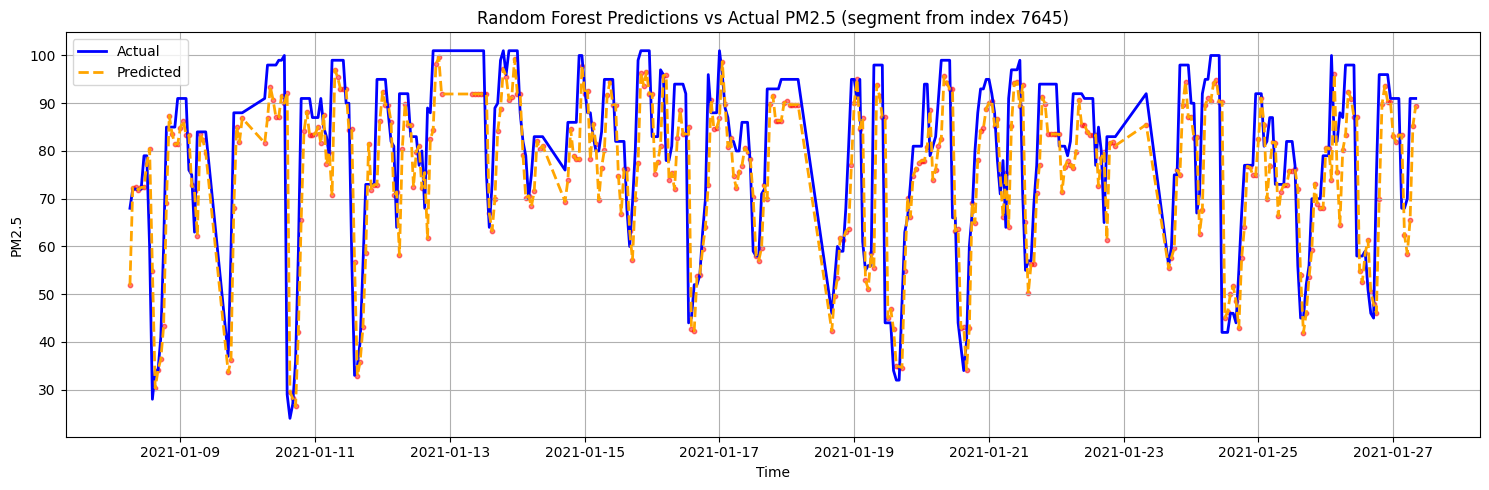

In [27]:
# Visual comparison of Random Forest predictions vs actual PM2.5 on the test period
import matplotlib.pyplot as plt
import numpy as np

# Number of points to visualize
n_points = 400  

# Random starting index
start_idx = np.random.randint(0, len(y_test) - n_points)

# Select segment
time_segment = test['local'].iloc[start_idx:start_idx + n_points]
y_true_segment = y_test[start_idx:start_idx + n_points]
rf_pred_segment = rf__y_pred[start_idx:start_idx + n_points]

plt.figure(figsize=(15,5))
plt.plot(time_segment, y_true_segment, label='Actual', color='blue', linewidth=2)
plt.plot(time_segment, rf_pred_segment, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.scatter(time_segment, rf_pred_segment, color='red', s=10, alpha=0.5)  # optional scatter
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.title(f"Random Forest Predictions vs Actual PM2.5 (segment from index {start_idx})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 3, 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 3, 1))


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(3, 1)),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


/Users/dashivam06/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=7,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred_scaled = model.predict(X_test_lstm)

# Convert back to original scale
lstm__y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)


lstm_mse = mean_squared_error(y_test_original, lstm__y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_original, lstm__y_pred)
lstm_r2 = r2_score(y_test_original, lstm__y_pred)


print("\n" + "╔══════════════════════════════════════════╗")
print("║      LSTM MODEL EVALUATION METRICS       ║")
print("╠══════════════════════════════════════════╣")
print(f"║  RMSE: {lstm_rmse:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  MSE:  {lstm_mse:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  MAE:  {lstm_mae:>30.6f}    ║")
print("╠══════════════════════════════════════════╣")
print(f"║  R²:   {lstm_r2:>30.6f}    ║")
print("╚══════════════════════════════════════════╝")



Epoch 1/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0582 - val_loss: 0.0110
Epoch 2/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 3/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 4/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 5/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 6/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - val_loss: 0.0091
Epoch 7/7
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120 - val_loss: 0.0091
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step

╔══════════════════════════════════════════╗
║      LSTM MODEL EVALUATION METRICS       ║
╠══════════════════════════════════════════╣
║  RMSE:                       9.672275    ║
╠══════════════════════════════════════════╣
║  MSE:                       93.552912    ║
╠══════════════════════════════════════════╣
║  MAE:                        5.974064    ║
╠

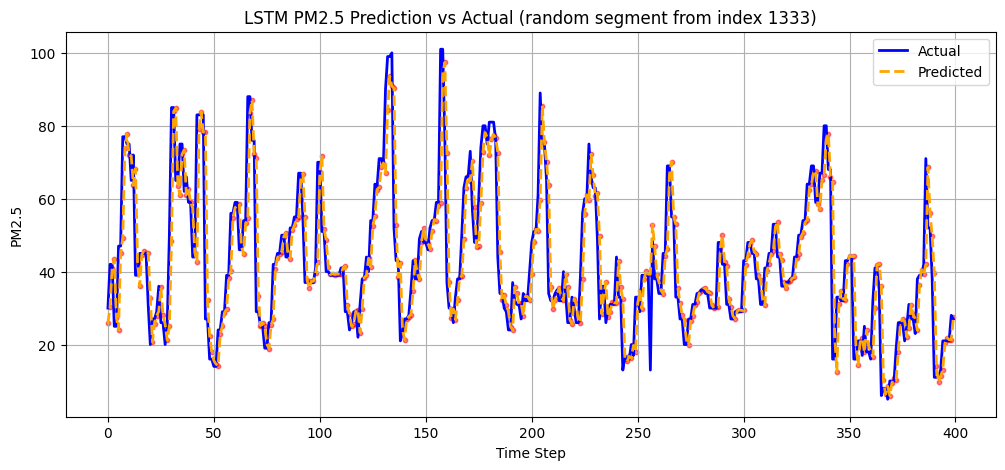

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Number of points to visualize
n_points = 400  # length of segment to plot

# Random starting index
start_idx = np.random.randint(0, len(y_test_original) - n_points)

y_true = y_test_original[start_idx:start_idx + n_points]
y_pred = lstm__y_pred[start_idx:start_idx + n_points]

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.scatter(range(n_points), y_pred, color='red', s=10, alpha=0.5)  # scatter to highlight predictions
plt.title(f"LSTM PM2.5 Prediction vs Actual (random segment from index {start_idx})")
plt.xlabel("Time Step")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()


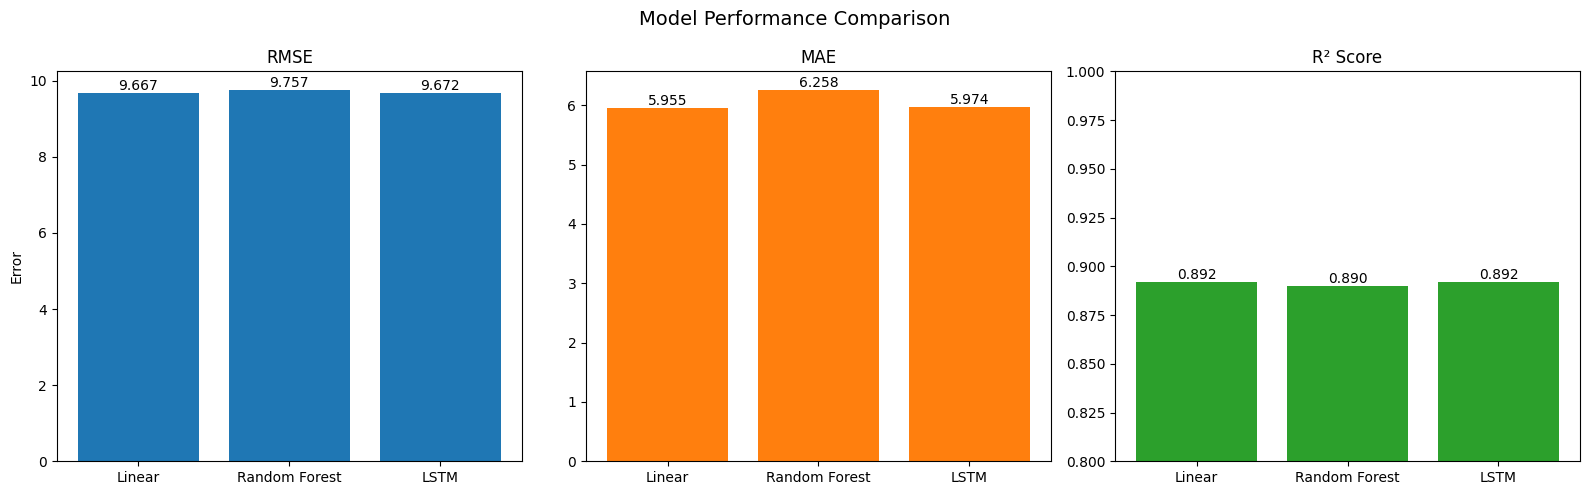

In [32]:

models = ["Linear", "Random Forest", "LSTM"]

rmse = [lg_rmse, rf_rmse, lstm_rmse]
mae  = [lg_mae, rf_mae, lstm_mae]
r2   = [lg_r2, rf_r2, lstm_r2]

fig, axes = plt.subplots(1, 3, figsize=(16,5))

def annotate_bars(ax, bars, decimals=3):
    """Add value labels on top of each bar"""
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                height,
                f"{height:.{decimals}f}",
                ha='center', va='bottom', fontsize=10)

# RMSE
bars_rmse = axes[0].bar(models, rmse, color='#1f77b4')  # blue
axes[0].set_title("RMSE")
axes[0].set_ylabel("Error")
annotate_bars(axes[0], bars_rmse)

# MAE
bars_mae = axes[1].bar(models, mae, color='#ff7f0e')  # orange
axes[1].set_title("MAE")
annotate_bars(axes[1], bars_mae)

# R2
bars_r2 = axes[2].bar(models, r2, color='#2ca02c')  # green
axes[2].set_title("R² Score")
axes[2].set_ylim(0.8, 1.0) 
annotate_bars(axes[2], bars_r2)

fig.suptitle("Model Performance Comparison", fontsize=14)
plt.tight_layout()
plt.show()
